In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE

import tensorflow.keras.regularizers as reg

###
import tensorflow.keras.utils as ku 
import numpy as np 

In [8]:
tokenizer = Tokenizer()
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
#    -O ./tmp/sonnets.txt
data = open('./tmp/nlp_w4/sonnets.txt', encoding="utf8").read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [52]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2,
                kernel_regularizer=reg.l2(0.01),
                activation='relu'))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 10, 1000)          3211000   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 10, 600)           3122400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 600)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 150)               450600    
_________________________________________________________________
dense_34 (Dense)             (None, 1605)              242355    
_________________________________________________________________
dense_35 (Dense)             (None, 3211)              5156866   
Total params: 12,183,221
Trainable params: 12,183,221
Non-trainable params: 0
_________________________________________

In [53]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 16s 1ms/sample - loss: 6.9159 - accuracy: 0.0221
Epoch 2/100
15462/15462 [==============================] - 13s 866us/sample - loss: 6.5334 - accuracy: 0.0221
Epoch 3/100
15462/15462 [==============================] - 13s 843us/sample - loss: 6.5295 - accuracy: 0.0266
Epoch 4/100
15462/15462 [==============================] - 13s 852us/sample - loss: 6.4537 - accuracy: 0.0276
Epoch 5/100
15462/15462 [==============================] - 13s 853us/sample - loss: 6.4130 - accuracy: 0.0294
Epoch 6/100
15462/15462 [==============================] - 13s 843us/sample - loss: 6.3603 - accuracy: 0.0292
Epoch 7/100
15462/15462 [==============================] - 13s 844us/sample - loss: 6.3130 - accuracy: 0.0317
Epoch 8/100
15462/15462 [==============================] - 13s 846us/sample - loss: 6.2828 - accuracy: 0.0329
Epoch 9/100
15462/15462 [==============================] - 13s 843us/sample - loss: 6.2465 - accura

15462/15462 [==============================] - 13s 862us/sample - loss: 5.9048 - accuracy: 0.0451
Epoch 75/100
15462/15462 [==============================] - 13s 858us/sample - loss: 5.9174 - accuracy: 0.0449
Epoch 76/100
15462/15462 [==============================] - 13s 846us/sample - loss: 5.9001 - accuracy: 0.0446
Epoch 77/100
15462/15462 [==============================] - 13s 864us/sample - loss: 5.9181 - accuracy: 0.0442
Epoch 78/100
15462/15462 [==============================] - 13s 852us/sample - loss: 5.9191 - accuracy: 0.0448
Epoch 79/100
15462/15462 [==============================] - 13s 849us/sample - loss: 5.9119 - accuracy: 0.0433
Epoch 80/100
15462/15462 [==============================] - 13s 854us/sample - loss: 5.9108 - accuracy: 0.0450
Epoch 81/100
15462/15462 [==============================] - 13s 851us/sample - loss: 5.9027 - accuracy: 0.0424
Epoch 82/100
15462/15462 [==============================] - 13s 862us/sample - loss: 5.8897 - accuracy: 0.0433
Epoch 83/100
1

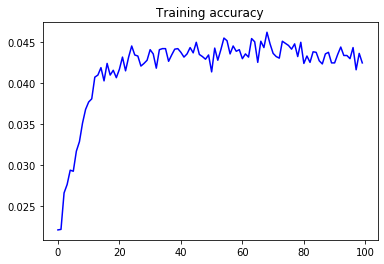

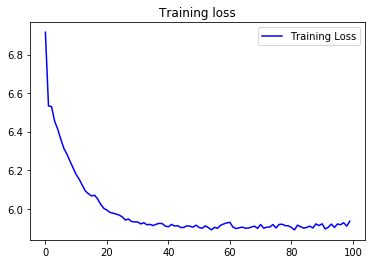

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline  

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [55]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope i have the sweet love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my love of my
